In [0]:
import json
import os
import pandas as pd
import pprint
import tensorflow as tf
import time
import numpy as np
from tensorflow import keras


%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
try:
  from pyforest import *
except:
  !pip install pyforest
  from pyforest import *

Using TensorFlow backend.


     |████████████████████████████████| 3.4MB 88kB/s 
  Created wheel for pyforest: filename=pyforest-0.1.1-py2.py3-none-any.whl size=9181 sha256=4a3533db32a6fd616cef202d1ebe14e701c52dbd6a4a0de66e32a42106d5c7b1
  Stored in directory: /root/.cache/pip/wheels/77/f9/78/51500678d6ce472b574216a40cba6c81d1766ee7cc838cce3c
Successfully built pyforest


In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9569358773955441345, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4179204216369772593
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10309291973322588943
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14912199066
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18271110165248578541
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [0]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

W0903 19:15:06.960701 140515499693952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0903 19:15:06.963724 140515499693952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0903 19:15:06.965722 140515499693952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:203: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0903 19:15:06.974380 140515499693952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
#from google.colab import files

#uploaded = files.upload()

!wget https://gitlab.com/DBertazioli/enercibiddding/raw/master/PyScripts/q_p_list.pickle

--2019-09-03 19:15:08--  https://gitlab.com/DBertazioli/enercibiddding/raw/master/PyScripts/q_p_list.pickle
Resolving gitlab.com (gitlab.com)... 35.231.145.151
Connecting to gitlab.com (gitlab.com)|35.231.145.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11150446 (11M) [application/octet-stream]
Saving to: ‘q_p_list.pickle’

q_p_list.pickle     100%[===================>]  10.63M  4.45MB/s    in 2.4s    

2019-09-03 19:15:12 (4.45 MB/s) - ‘q_p_list.pickle’ saved [11150446/11150446]



In [0]:
from IPython.display import clear_output


class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses)%50==0:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()


In [0]:
with open("q_p_list.pickle", "rb") as infile:
  S=pickle.load(infile)

In [0]:
#df=pd.read_csv("q_p_list (2).csv")
#df=pd.read_csv("https://gitlab.com/DBertazioli/enercibiddding/raw/master/PyScripts/q_p_list.csv")

In [0]:
#df.head()

In [0]:
#S1=df["0"]
S1=S[1]
#S1.head()

In [0]:
S1=pd.Series(S1)
#S1.shape

In [0]:
train_y=S1[1:4500]
val_y=S1[4500:5500]
test_y=S1[5500:-1]

train_X=S1[2:4501]
val_X=S1[4501:5501]
test_X=S1[5501:]

In [0]:
train_X=np.asarray(train_X).reshape(train_X.shape[0],1, 1)
train_X.shape

(4499, 1, 1)

In [0]:
test_X=np.asarray(test_X).reshape(test_X.shape[0],1, 1)
test_X.shape

(1651, 1, 1)

In [0]:
val_X=np.asarray(val_X).reshape(val_X.shape[0], 1, 1)
val_X.shape

(1000, 1, 1)

In [0]:
model = Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(train_X.shape[1],1)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.compile(loss='mae', optimizer=tf.train.AdamOptimizer())

W0903 14:16:12.660902 140217188587392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0903 14:16:13.419415 140217188587392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
# fit network
history = model.fit(train_X, train_y, epochs=10000, batch_size=256, validation_data=(val_X, val_y), verbose=2, shuffle=False)
# plot history

W0903 14:16:13.710376 140217188587392 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 4499 samples, validate on 1000 samples
Epoch 1/10000
 - 3s - loss: 744.2964 - val_loss: 1175.5129
Epoch 2/10000
 - 0s - loss: 744.1041 - val_loss: 1175.2446
Epoch 3/10000
 - 0s - loss: 743.6980 - val_loss: 1174.6007
Epoch 4/10000
 - 0s - loss: 742.7650 - val_loss: 1173.2727
Epoch 5/10000
 - 0s - loss: 741.0032 - val_loss: 1170.9638
Epoch 6/10000
 - 0s - loss: 738.4367 - val_loss: 1168.2506
Epoch 7/10000
 - 0s - loss: 736.3754 - val_loss: 1167.0852
Epoch 8/10000
 - 0s - loss: 735.5451 - val_loss: 1166.3658
Epoch 9/10000
 - 0s - loss: 734.8701 - val_loss: 1165.7138
Epoch 10/10000
 - 0s - loss: 734.2482 - val_loss: 1165.1052
Epoch 11/10000
 - 0s - loss: 733.6632 - val_loss: 1164.5269
Epoch 12/10000
 - 0s - loss: 733.1034 - val_loss: 1163.9701
Epoch 13/10000
 - 0s - loss: 732.5625 - val_loss: 1163.4300
Epoch 14/10000
 - 0s - loss: 732.0365 - val_loss: 1162.9027
Epoch 15/10000
 - 0s - loss: 731.5221 - val_loss: 1162.3857
Epoch 16/10000
 - 0s - loss: 731.0166 - val_loss: 1161.8768
E

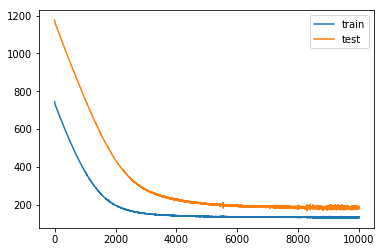

In [0]:
%matplotlib inline

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
#plt.plot(history.history['acc'], label='train')

plt.legend()
plt.show()

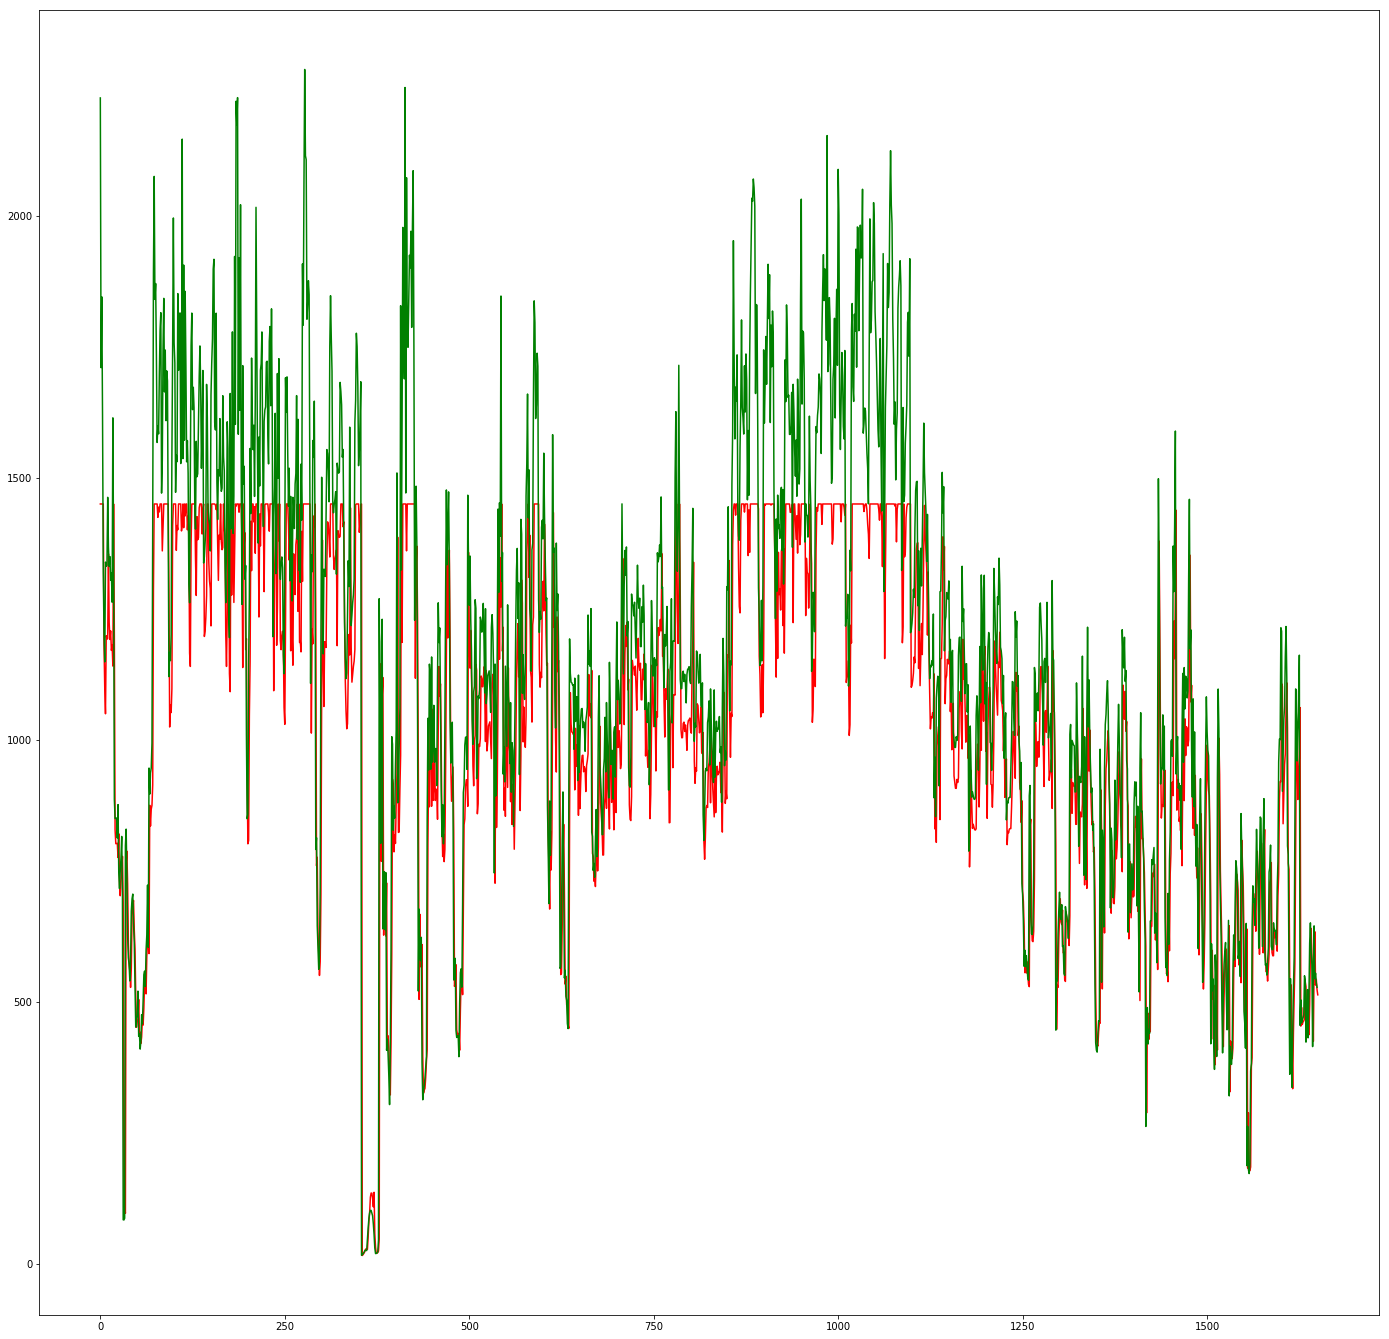

In [0]:
predicted_value= model.predict(test_X)
plt.figure(figsize=(24,24))
plt.plot(predicted_value, color= 'red')
plt.plot(test_X[1:,0], color='green')


In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# later...
"""
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# evaluate loaded model on test data

loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
""";

In [0]:
from google.colab import files

model_json = model.to_json()
with open("model1.json","w") as json_file:
     json_file.write(model_json)

files.download("model1.json")

In [0]:
model.save('weights.h5')
files.download('weights.h5')

NameError: ignored

In [0]:
from google.colab import files

files.upload()

Saving model1.json to model1.json
Saving weights.h5 to weights.h5


{'model1.json': b'{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "LSTM", "config": {"name": "lstm_1", "trainable": true, "batch_input_shape": [null, 1, 1], "dtype": "float32", "return_sequences": true, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "units": 30, "activation": "tanh", "recurrent_activation": "hard_sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "recurrent_initializer": {"class_name": "Orthogonal", "config": {"gain": 1.0, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "unit_forget_bias": true, "kernel_regularizer": null, "recurrent_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "recurrent_constraint": null, "bias_constraint": null, "dropout": 0.0, "recurrent_dropout": 0.0, "implementation": 1

In [0]:
# load json and create model
json_file = open('model1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("weights.h5")
print("Loaded model from disk")

# evaluate loaded model on test data

loaded_model.compile(loss='mae', optimizer=tf.train.AdamOptimizer())

W0903 19:18:18.409368 140515499693952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Loaded model from disk


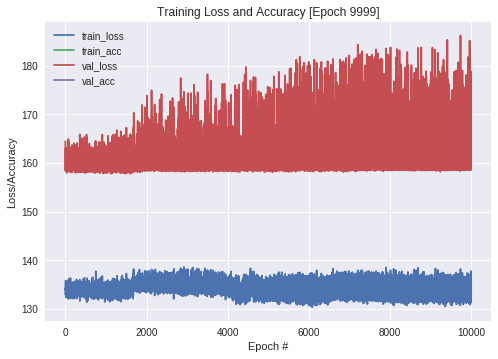

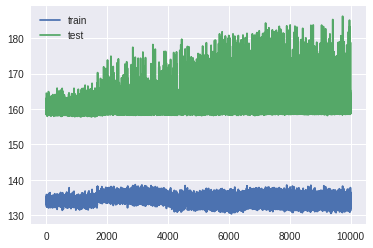

CPU times: user 40min 1s, sys: 2min 35s, total: 42min 37s
Wall time: 30min 3s


In [37]:
%%time
# fit network
history = loaded_model.fit(train_X, train_y, epochs=10000, batch_size=256, validation_data=(val_X, val_y), verbose=0, shuffle=False, callbacks=[plot_losses])
# plot history
%matplotlib inline

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
#plt.plot(history.history['acc'], label='train')

plt.legend()
plt.show()

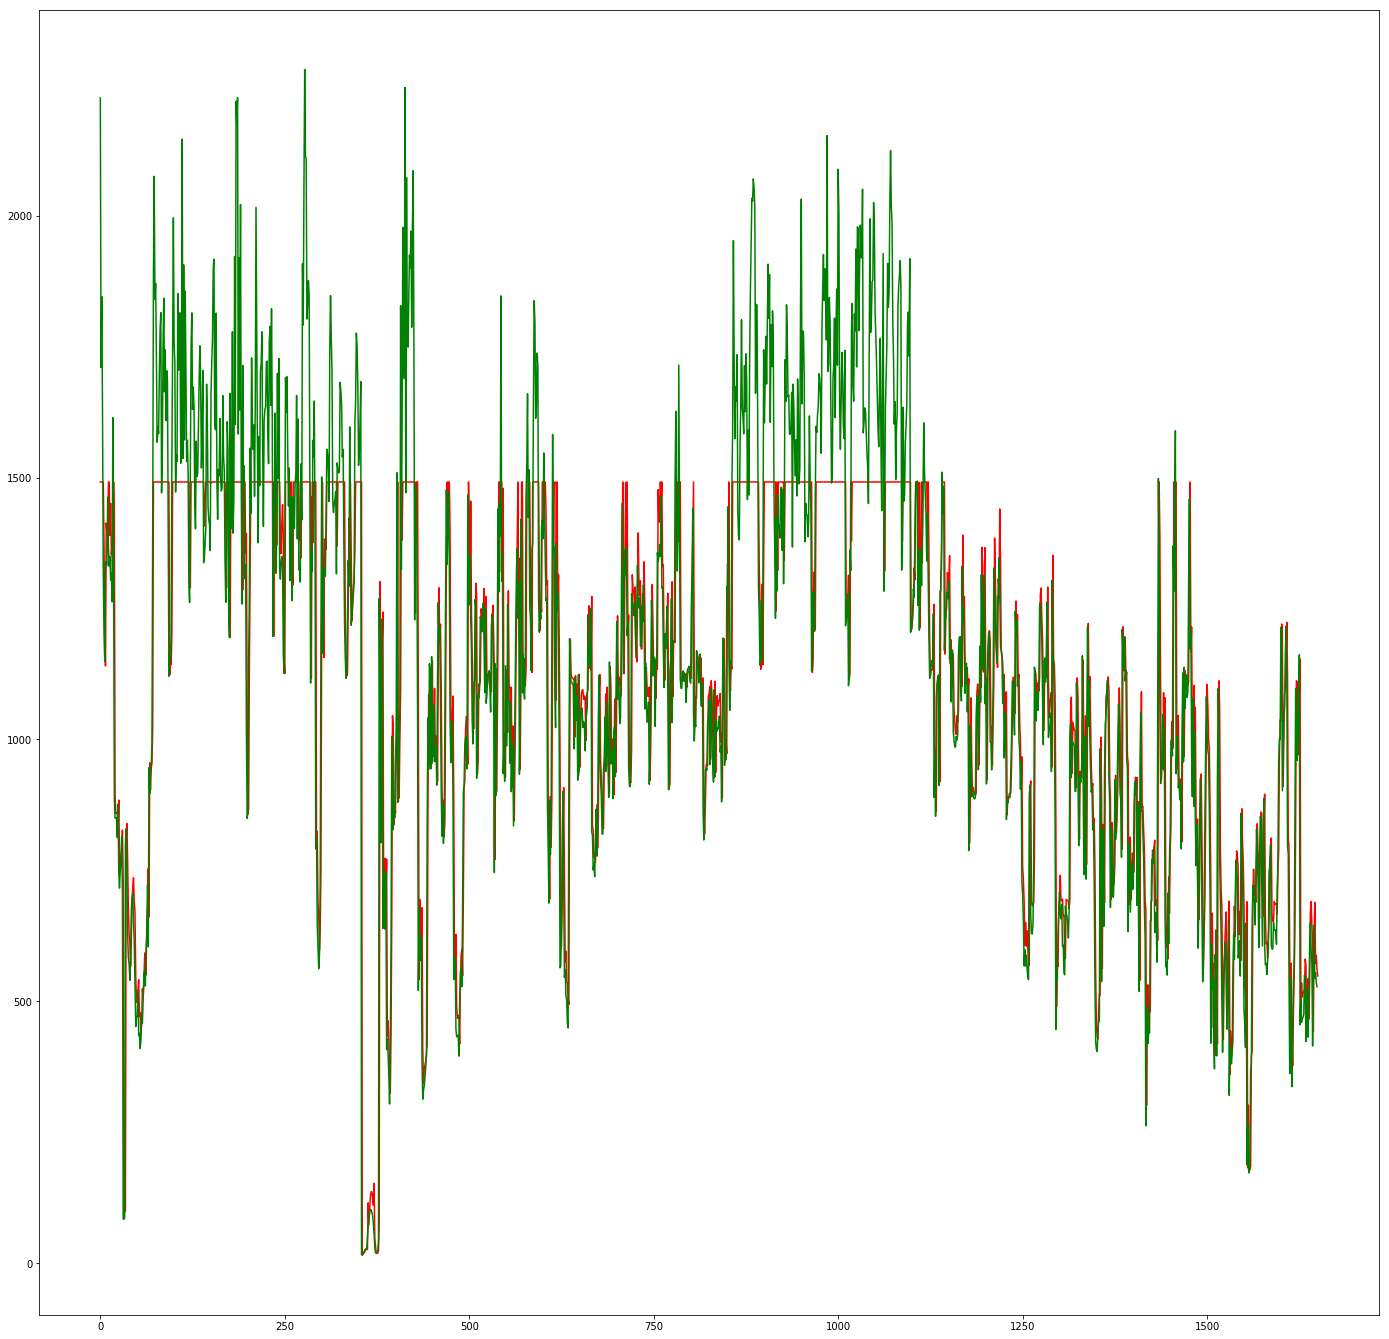

In [28]:
#plot at 20000 epochs
predicted_value= loaded_model.predict(test_X)
plt.figure(figsize=(24,24))
plt.plot(predicted_value, color= 'red')
plt.plot(test_X[1:,0], color='green')


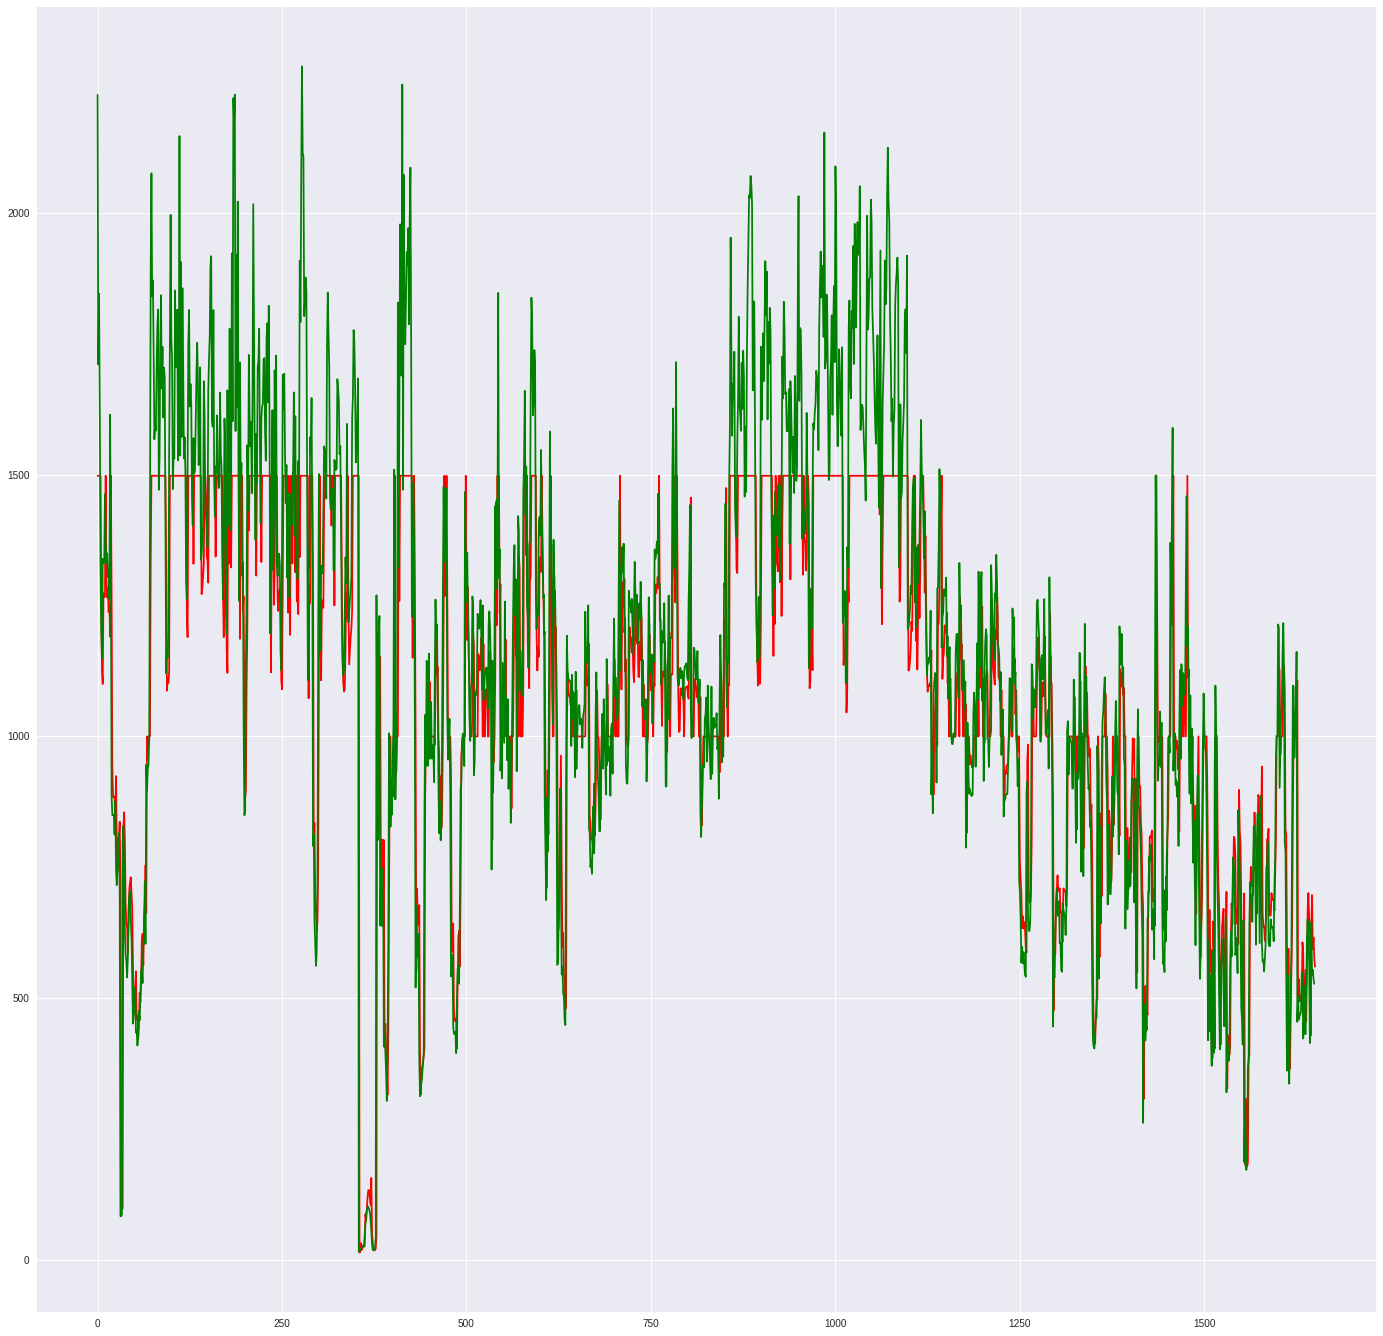

In [38]:
#plot at 30000 epochs
predicted_value= loaded_model.predict(test_X)
plt.figure(figsize=(24,24))
plt.plot(predicted_value, color= 'red')
plt.plot(test_X[1:,0], color='green')
